# Airbnb - Machine Learning Project
***
Chicago Listings & Reviews - 09/2019
<br/>
http://insideairbnb.com/get-the-data.html

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

from datetime import datetime
import time
import xgboost as xgb

## Initial General Cleaning

In [2]:
raw_df = pd.read_csv('data/list_gz.csv', low_memory = False)

# print(f"Contains {len(raw_df):,} Airbnb listings")
# print(f"Contains {len(raw_df.columns):,} columns")

print(raw_df.info())

pd.set_option('display.max_columns', len(raw_df.columns))

raw_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8852 entries, 0 to 8851
Columns: 106 entries, id to reviews_per_month
dtypes: float64(21), int64(23), object(62)
memory usage: 7.2+ MB
None


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20190922191701,2019-09-22,Hyde Park Private Room - Pleasant Walk to UChi...,You are invited to be the sole Airbnb guest in...,"The private bedroom has a queen size bed, beds...",You are invited to be the sole Airbnb guest in...,none,My apartment is one block from beautiful Jacks...,The basement laundry room hours are 8:00am to ...,UNIVERSITY OF CHICAGO: Visiting academics and ...,You will have access to the entire apartment -...,I will greet you when you arrive and show you ...,1. Your booking is for ONE (1) guest only - th...,NaN,NaN,https://a0.muscache.com/im/pictures/acf6b3c0-4...,NaN,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1,1,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, IL, United States",Hyde Park,Hyde Park,NaN,Chicago,IL,60637,Chicago,"Chicago, IL",US,United States,41.78886,-87.58671,t,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",NaN,$50.00,$350.00,NaN,$0.00,$20.00,1,$0.00,2,91,2,2,91,91,2.0,91.0,3 weeks ago,t,2,28,55,330,2019-09-22,170,38,2015-01-09,2019-09-16,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""Illinois State"","" Cook County"","" IL"","" CHICA...",t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.97
1,4505,https://www.airbnb.com/rooms/4505,20190922191701,2019-09-22,One Great Apartment. 377 Great Reviews. 1 Bad ...,"We took the winter off, made things nicer arou...","We travel a lot, we know what people need. We...","We took the winter off, made things nicer arou...",none,NaN,NaN,The CTA train station is 30 yards (27 meters) ...,We also have a huge yard. Use it (weather perm...,NaN,Don't sit around all day watching T.V. Don't h...,NaN,NaN,https://a0.muscache.com/im/pictures/15019798/7...,NaN,5775,https://www.airbnb.com/users/show/5775,Craig & Kathleen,2008-12-29,"Chicago, Illinois, United States",Incredibly creative(Kathleen) and stunningly a...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/5775/profile_...,https://a0.muscache.com/im/use

# Preemptively Comparing Price, Space, Lat, and Long

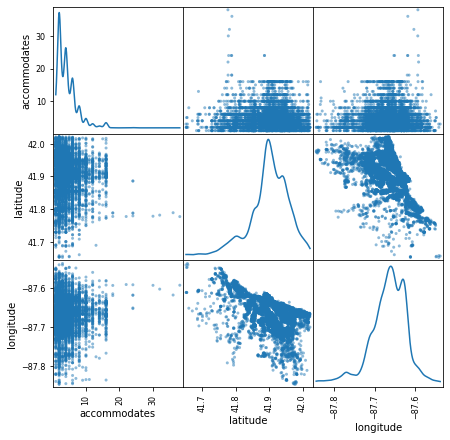

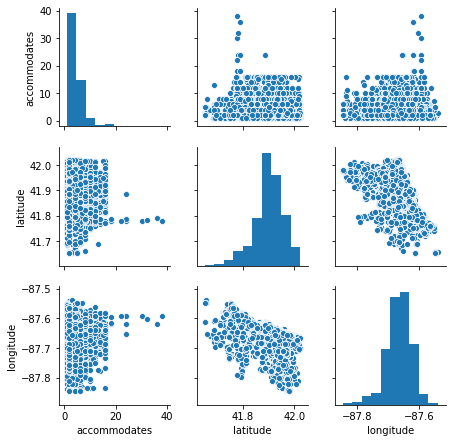

In [3]:
air_df = raw_df.copy()

temp = air_df[['price', 'accommodates','latitude', 'longitude']]

pd.plotting.scatter_matrix(temp, figsize = (7, 7), diagonal = 'kde');

import seaborn as sns
sns.pairplot(temp, height=2.1);

In [4]:
air_df['price'] = air_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

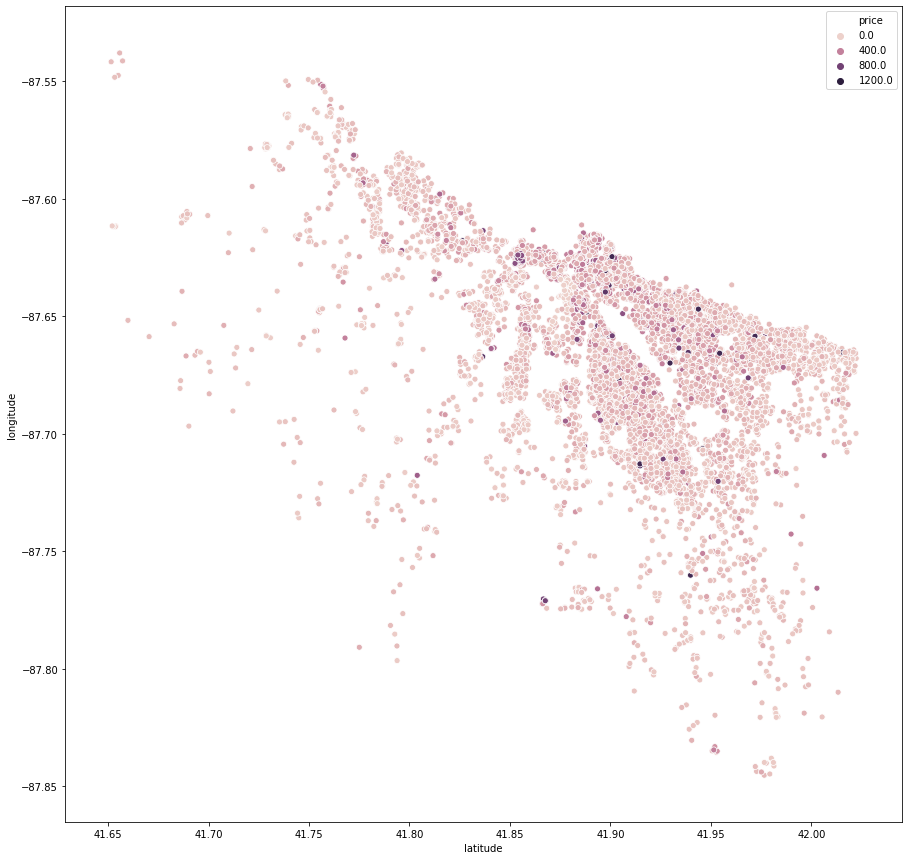

In [9]:
temp = air_df[air_df.price < 1100]
plt.figure(figsize=(15,15))
sns.scatterplot(x='latitude', y='longitude', hue='price', data = temp)

#### Dropping Null Values

In [ ]:
del seaborn

air_df = raw_df.copy()

print(air_df['experiences_offered'].value_counts())

temp = air_df.isna().sum().sort_values(ascending = False)
temp = pd.DataFrame(temp).reset_index()

temp.head(10)

In [ ]:
temp = temp[temp[0] > len(air_df)/2]
temp = temp['index'].tolist()

temp

In [ ]:
air_df = air_df.drop(temp, axis=1)

del temp 

air_df.head(2)

#### Converting Strings into Floats and Changing T/F Response Values

In [ ]:
temp = ['price', 
        'security_deposit', 
        'cleaning_fee', 
        'extra_people' 
       ]

for col in temp:
    air_df[col] = air_df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)
    
del temp    

air_df['price'].head()

In [ ]:
air_df.replace({'f': 0, 't': 1}, inplace=True)

air_df['instant_bookable'].head(2)

#### Separating Column Names by Type
This portion does not deal with NLP at the time of the project

In [ ]:
temp = air_df.dtypes.apply(lambda x: x.name).to_dict()

dict(list(temp.items())[:5])

In [ ]:
str_col = []

for key, val in temp.items():
    if val == 'object': 
        str_col.append(key)
    else:
        pass

del temp

print(f'{len(str_col)} string columns')
str_col

In [ ]:
temp = ['neighbourhood', 
       'neighbourhood_cleansed', 
       'property_type', 
       'room_type', 
       'bed_type'
       ]

temp = list(set(str_col) - set(temp))

print(f'{len(temp)} string columns')
temp

In [ ]:
air_df = air_df.drop(temp, axis=1)
del temp

air_df.head(2)

#### Investigating Remaining String Columns Further

In [ ]:
# https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago
# neighbourhood_cleaned seems to be community
# neighbourhood offers more variability and will be kept

air_df[['neighbourhood', 'neighbourhood_cleansed']].head(10)

In [ ]:
temp = ['property_type', 
        'room_type', 
        'bed_type'
       ]

for x in temp:
    print(f'\n{x}:')
    print(air_df[x].value_counts())
    
del temp

In [ ]:
temp = ['id', 
        'scrape_id', 
        'host_id', 
        'neighbourhood_cleansed', 
        'bed_type'
       ]

air_df = air_df.drop(temp, axis=1).copy()
del temp

air_df.head(2)

In [ ]:
air_df.hist(figsize=(25,25));

In [ ]:
# storing lat/long coordinates in case decide to use them later

lat_lng = air_df[['latitude','longitude']]
lat_lng.head(2)

In [ ]:
# minimum_nights
# minimum_minimum_nights
# maximum_minimum_nights

# maximum_nights
# minimum_maximum_nights
# maximum_maximum_nights

# average nights
# minimum_nights_avg_ntm
# maximum_nights_avg_ntm

print(f' Min. diffs.: {sum((air_df.minimum_nights == air_df.minimum_minimum_nights) == False)}')
print(f' Max. diffs.: {sum((air_df.maximum_nights == air_df.maximum_maximum_nights) == False)}')

In [ ]:
# 'host_total_listings_count', 
# 'calculated_host_listings_count', 
# 'calculated_host_listings_count_entire_homes', 
# 'calculated_host_listings_count_private_rooms', 
# 'calculated_host_listings_count_shared_rooms'

print(f'Tot.: {sum((air_df.host_listings_count == air_df.host_total_listings_count) == False)}')
# print(f'Calc.: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count) == False)}')
# print(f'Calc. Homes: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_entire_homes) == False)}')
# print(f'Calc. Priv.: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_private_rooms) == False)}')
# print(f'Calc. Shared: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_shared_rooms) == False)}')

Both the `host_listings_count` and `host_total_listings_count` have the same values. One will be dropped

In [ ]:
temp = ['host_total_listings_count', 
        'host_total_listings_count', 
        'calculated_host_listings_count', 
        'calculated_host_listings_count_entire_homes', 
        'calculated_host_listings_count_private_rooms', 
        'calculated_host_listings_count_shared_rooms', 
        'minimum_minimum_nights', 
        'maximum_minimum_nights', 
        'minimum_maximum_nights', 
        'maximum_maximum_nights', 
        'minimum_nights_avg_ntm', 
        'maximum_nights_avg_ntm', 
        'is_location_exact', 
        'has_availability', 
        'host_has_profile_pic', 
        'is_business_travel_ready', 
        'require_guest_phone_verification', 
        'require_guest_profile_picture', 
        'requires_license']

air_df = air_df.drop(temp, axis=1)

del temp

air_df.head(2)

In [ ]:
from pprint import pprint

test = air_df.columns.tolist()
pprint(test)

del pprint 

air_df.hist(figsize=(25,25));

#  reviews in-depth to figure which to drop, maybe all

In [ ]:
sum((air_df.minimum_nights == air_df.minimum_minimum_nights) == False)

In [ ]:
# import seaborn as sns

# sns.pairplot(air_df, size=2.5)
# plt.tight_layout()

In [ ]:
cols_to_drop = ['host_total_listings_count', 
                'calculated_host_listings_count', 
                'calculated_host_listings_count_entire_homes', 
                'calculated_host_listings_count_private_rooms', 
                'calculated_host_listings_count_shared_rooms', 
                'license'
               ]

air_df.drop(cols_to_drop, axis=1)

air_df.head()

In [ ]:
air_df['cancellation_policy'].value_counts()

In [ ]:
temp = ['calendar_updated', 
        'has_availability', 
        'availability_30', 
        'availability_60',
        'availability_90',
        'availability_365'
       ]

for col in temp:
    print(f'{col}:\n{air_df[col].value_counts()}\n')

In [ ]:
lat_long_df = air_df[['latitude', 'longitude']].copy()

cols_to_drop = ['zipcode', 
                'latitude', 
                'longitude', 
                'street', 
                'neighbourhood', 
                'city', 
                'state', 
                'market', 
                'smart_location', 
                'country_code', 
                'country'
               ]

air_df.drop(cols_to_drop, axis=1)
air_df.head()

In [ ]:
sum((air_df.minimum_nights == air_df.minimum_minimum_nights) == False)

In [ ]:
air_df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1)

In [ ]:
temp = air_df[['price', 'accommodates', 'bathrooms', 'bedrooms', 'review_scores_rating', 'guests_included', 'minimum_nights']]

pd.plotting.scatter_matrix(temp, alpha=0.2, figsize=(25, 25), diagonal='kde')

#### Correlations between: <br/>
Accommodate & (bathrooms, bedrooms) <br/>
Batrooms & bedrooms <br/>
slight between bedrooms/accommodates & price
*** 
need to get dummies for neighborhoods, etc and then visualize



# THIS IS THE START OF MODEL TESTING

# Testing univariate KNN without cleaning or fitting

In [ ]:
temp = raw_df.copy()
temp = raw_df[['price', 'accommodates']].copy()

temp['price'] = temp['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

temp.head()

### KNN Method # 1

In [ ]:
y = temp['price']
X = temp.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 

In [ ]:
train_scores = []
test_scores = []

for k in range(1, 100, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
plt.plot(range(1, 100, 2), train_scores, marker='o', label='Train')
plt.plot(range(1, 100, 2), test_scores, marker="x", label='Test')
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.legend()
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=93)
knn.fit(X_train, y_train)
print('k=93 Test Acc: %.3f' % knn.score(X_test, y_test))

### KNN Regressor

In [ ]:
len(y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

train_df = temp.iloc[0:2213]
test_df = temp.iloc[2213:]

train_columns = ['accommodates']

knn = KNeighborsRegressor(n_neighbors=93, algorithm='auto')
# knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

features = train_df.columns.tolist()
features.remove('price')
knn.fit(train_df[features], train_df['price'])

all_features_predictions = knn.predict(test_df[features])
all_features_mse = mean_squared_error(test_df['price'], all_features_predictions)
all_features_rmse = all_features_mse ** (1/2)

print(f'MSE: ${all_features_mse:,.2f}')
print(f'RMSE: ${all_features_rmse:,.2f}')

In [ ]:
import StringIO

In [ ]:
a = np.random.randint(0,256,(10,10)).astype('uint8')
b = pd.DataFrame(a)


# temp = b.dtypes.apply(lambda x: x.name).to_dict()

# dict(list(temp.items())[:5])

c = StringIO()
b.to_csv(c, sep=' ', header=False, index=False)
c.seek(0)
# d = pd.read_csv(c, sep=' ', header=None, dtype='uint8')
# d

In [ ]:
test = raw_df[['id','name']].copy()
test.head()

x = 'One Great Apartment. 377 Gre'

blank = []

for j in test['name'][:3]:
    for i in j: 
        if i.isdigit():
            print(i)
#     [int(i) for i in j.split() if i.isdigit()] 

In [ ]:
def find_letter(letter, lst):
    return any(letter in word for word in lst)

In [ ]:
find_letter('n',x)

In [ ]:
test['name'][:3]

In [ ]:
test_df = pd.read_csv('list_gz.csv', low_memory = False)
print(test_df.info())
pd.set_option('display.max_columns', len(test_df.columns))

test_df.head()